##**IMPORTANDO AS BIBLIOTECAS/MÓDULOS**

* gcsfs -> conexão com o GCP
* pymongo -> Conexão com o MongoDB
* pandas -> manipulação e análise de dados
* pyspark -> framework para processar grandes quantidades de dados
* fsspec -> projeto para fornecer uma interface Python unificada para sistemas de arquivos locais, remotos e incorporados e armazenamento de bytes.
* pandera -> validação de schema

In [1]:
!pip install gcsfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 7.6 MB/s 
     |████████████████████████████████| 1.1 MB 47.3 MB/s 
     |████████████████████████████████| 144 kB 59.2 MB/s 
     |████████████████████████████████| 271 kB 45.9 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 


In [2]:
!pip install pymongo 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 52.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=658b1760e07fe427e0d3ca649e2c5d76df0685b86d92d11cff236cdf2deb6b95
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [5]:
pip install fsspec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install pandera

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 5.2 MB/s 
     |████████████████████████████████| 11.1 MB 64.0 MB/s 


* psycopg2 -> Adaptador Postgres
* requests -> Solicitações HTTP em Python
* pymongo -> Conexão com o MongoDB
* sqlalchemy -> Mapeamento Objeto Relacional
* datetime -> fornece as classes para manipulação de datas e horas
* csv -> ler e gravar arquivos .csv
* collections -> trabalhar com dados de maneira eficiente
* numpy -> processamento de grandes, multi-dimensionais arranjos e matrizes, juntamente com uma grande coleção de funções matemáticas de alto nível para operar sobre estas matrizes
* pandera -> validação do schema

In [7]:
import psycopg2
import requests
import pymongo
import sqlalchemy
import datetime
import csv
import collections
import numpy as np
import pandera as pa

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


* Pandas -> análise e manipulação de dados
* os -> automação de processos em Python
* storage -> armazenamento em nuvem

In [8]:
import pandas as pd
import pyspark.sql.functions as F
from google.cloud import storage

In [9]:
import os

In [10]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import isnull, isnan, when, count, col
from pyspark.sql.functions import *
from pyspark.sql.functions import ceil, col

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**CONEXÃO GCP**

INCLUINDO A CHAVE DE SEGURANÇA DO GCP

In [12]:
serviceAccount = '/content/drive/MyDrive/projeto-final-the-last-dance-8b51b88868a6.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

ACESSANDO O BUCKET

In [13]:
acesso = storage.Client()

bucket = acesso.get_bucket('projeto-final')

CRIANDO O DATAFRAME

In [14]:
bucket.blob('Mortalidade_Geral_2018.csv')

<Blob: projeto-final, Mortalidade_Geral_2018.csv, None>

In [15]:
path = 'gs://projeto-final/arq-original/Mortalidade_Geral_2018.csv'

CONVERTENDO ARQUIVO CID -> JSON EM CSV

In [16]:
df_cid = pd.read_json('gs://projeto-final/arq-original/cid10.json')

In [17]:
df_cid.codigo=df_cid.codigo.str.replace('.','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [18]:
df_cid.to_csv('gs://projeto-final/arq-original/cid10.csv', index=False)

##**NORMALIZAÇÃO E TRATAMENTO COM PYSPARK**

CONEXÃO COM A SPARKSESSION

In [19]:
spark = ( SparkSession.builder
                        .master("local")
                        .appName("projeto-final")
                        .config("spark.ui.port", "4050")
                        .config("spark.jars", 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar')
                        .getOrCreate() 
        )

In [20]:
spark_2018 = ( spark.read.format('csv')
                       .option('header', 'true')
                       .option('inferschema', 'true')
                       .option('delimiter', ';')
                       .load('gs://projeto-final/arq-original/Mortalidade_Geral_2018.csv')
)

In [21]:
df_cid1 = ( spark.read.format("csv")
                  .option("header", "true")
                  .option("inferschema", "true")
                  .option("delimiter", ",")
                  .load('gs://projeto-final/arq-original/cid10.csv')
)

In [22]:
df_uf1 = ( spark.read.format("csv")
                  .option("header", "true")
                  .option("inferschema", "true")
                  .option("delimiter", ",")
                  .load('gs://projeto-final/arq-original/Arquivos auxiliares/UF-Munic.csv')
)

PRÉ-ANALISE DOS DADOS -> DF SPARK_2018

In [23]:
spark_2018.count()

1316719

In [24]:
spark_2018.dtypes

[('ORIGEM', 'int'),
 ('TIPOBITO', 'int'),
 ('DTOBITO', 'int'),
 ('HORAOBITO', 'int'),
 ('NATURAL', 'int'),
 ('CODMUNNATU', 'int'),
 ('DTNASC', 'int'),
 ('IDADE', 'int'),
 ('SEXO', 'int'),
 ('RACACOR', 'int'),
 ('ESTCIV', 'int'),
 ('ESC', 'int'),
 ('ESC2010', 'int'),
 ('SERIESCFAL', 'int'),
 ('OCUP', 'int'),
 ('CODMUNRES', 'int'),
 ('LOCOCOR', 'int'),
 ('CODESTAB', 'int'),
 ('ESTABDESCR', 'string'),
 ('CODMUNOCOR', 'int'),
 ('IDADEMAE', 'int'),
 ('ESCMAE', 'int'),
 ('ESCMAE2010', 'int'),
 ('SERIESCMAE', 'int'),
 ('OCUPMAE', 'int'),
 ('QTDFILVIVO', 'int'),
 ('QTDFILMORT', 'int'),
 ('GRAVIDEZ', 'int'),
 ('SEMAGESTAC', 'int'),
 ('GESTACAO', 'int'),
 ('PARTO', 'int'),
 ('OBITOPARTO', 'int'),
 ('PESO', 'int'),
 ('TPMORTEOCO', 'int'),
 ('OBITOGRAV', 'int'),
 ('OBITOPUERP', 'int'),
 ('ASSISTMED', 'int'),
 ('EXAME', 'int'),
 ('CIRURGIA', 'int'),
 ('NECROPSIA', 'int'),
 ('LINHAA', 'string'),
 ('LINHAB', 'string'),
 ('LINHAC', 'string'),
 ('LINHAD', 'string'),
 ('LINHAII', 'string'),
 ('CAUSABAS'

In [25]:
spark_2018.show(1)

+------+--------+--------+---------+-------+----------+-------+-----+----+-------+------+---+-------+----------+------+---------+-------+--------+----------+----------+--------+------+----------+----------+-------+----------+----------+--------+----------+--------+-----+----------+----+----------+---------+----------+---------+-----+--------+---------+------+------+------+------+-------+--------+------+----------+----------+---------+--------+-----+----------+-----+----------+----------+----------+---------+----------+----------+----------+---------+--------+---------+--------+----------+--------+----------+----------+----------+--------+-------+----------+----------+--------+----------+--------+------+----------+----------+---------+--------+----------+---------+---------+--------+--------+
|ORIGEM|TIPOBITO| DTOBITO|HORAOBITO|NATURAL|CODMUNNATU| DTNASC|IDADE|SEXO|RACACOR|ESTCIV|ESC|ESC2010|SERIESCFAL|  OCUP|CODMUNRES|LOCOCOR|CODESTAB|ESTABDESCR|CODMUNOCOR|IDADEMAE|ESCMAE|ESCMAE2010|SE

In [26]:
#CONTANDO OS CAMPOS "NULL" DE CADA COLUNA DO DF
spark_2018.select([count(when(isnull(c), c)).alias(c) for c in spark_2018.columns]).show()

+------+--------+-------+---------+-------+----------+------+-----+----+-------+------+------+-------+----------+------+---------+-------+--------+----------+----------+--------+-------+----------+----------+-------+----------+----------+--------+----------+--------+-------+----------+-------+----------+---------+----------+---------+-------+--------+---------+------+------+------+-------+-------+--------+-------+----------+----------+---------+--------+-------+----------+------+----------+----------+----------+---------+----------+----------+----------+---------+--------+---------+--------+----------+--------+----------+----------+----------+--------+-------+----------+----------+--------+----------+--------+-------+----------+----------+---------+--------+----------+---------+---------+--------+--------+
|ORIGEM|TIPOBITO|DTOBITO|HORAOBITO|NATURAL|CODMUNNATU|DTNASC|IDADE|SEXO|RACACOR|ESTCIV|   ESC|ESC2010|SERIESCFAL|  OCUP|CODMUNRES|LOCOCOR|CODESTAB|ESTABDESCR|CODMUNOCOR|IDADEMAE| ESC

DROPANDO COLUNAS QUE NÃO SERÃO UTILIZADAS

In [27]:
spark_2018 = spark_2018.drop(*('ORIGEM','HORAOBITO','ESTCIV','ESC','ESC2010','SERIESCFAL','CODMUNRES','IDADEMAE','ESCMAE','ESCMAE2010','SERIESCMAE','OCUPMAE','QTDFILMORT','GRAVIDEZ','SEMAGESTAC','GESTACAO','PARTO','OBITOPARTO','PESO','TPMORTEOCO','ASSISTMED','EXAME','CIRURGIA','NECROPSIA','CB_PRE','COMUNSVOIM','DTATESTADO','ACIDTRAB','NUMEROLOTE','DTINVESTIG','DTCADASTRO','ATESTANTE','STCODIFICA','CODIFICADO','VERSAOSIST','VERSAOSCB','FONTEINV','DTRECEBIM','ATESTADO','DTRECORIGA','CAUSAMAT','ESCMAEAGR1','ESCFALAGR1','DTCADINV','DTCONINV','FONTES','TPRESGINFO','TPNIVELINV','DTCADINF','MORTEPARTO','DTCONCASO','ALTCAUSA','TPPOS','TP_ALTERA','CB_ALT','CIRCOBITO','FONTE','NUDIASOBCO','TPOBITOCOR','QTDFILVIVO','OBITOGRAV','OBITOPUERP','LINHAA','LINHAB','LINHAC','LINHAD','LINHAII','IDADE','NUDIASOBIN', 'NUDIASINF', 'FONTESINF','ESTABDESCR','NATURAL','CODMUNNATU','DIFDATA','CONTADOR'))

In [28]:
spark_2018.show(5)

+--------+--------+--------+----+-------+------+-------+--------+----------+--------+----------+----------+--------+
|TIPOBITO| DTOBITO|  DTNASC|SEXO|RACACOR|  OCUP|LOCOCOR|CODESTAB|CODMUNOCOR|CAUSABAS|CAUSABAS_O|STDOEPIDEM|STDONOVA|
+--------+--------+--------+----+-------+------+-------+--------+----------+--------+----------+----------+--------+
|       2|25042018| 3111965|   1|      1|214120|      2| 2281147|    330010|     R99|       R99|         0|       1|
|       2|24052018|20052018|   2|      5|  null|      5|    null|    120032|    P002|      null|         0|       1|
|       2|14022018| 2061925|   1|      5|  null|      3|    null|    120030|    I219|      null|         0|       1|
|       2|31072018|25081928|   2|      5|  null|      3|    null|    120030|    J159|      null|         0|       1|
|       2|21092018| 4071941|   1|      4|999993|      3|    null|    120005|    C711|      C711|         0|       1|
+--------+--------+--------+----+-------+------+-------+--------

COMANDO PARA RENOMEAR COLUNAS

In [29]:
spark_2018 = spark_2018.withColumnRenamed("contador", "SEQUENCIA").withColumnRenamed("TIPOBITO", "TIPO_OBITO").withColumnRenamed("DTOBITO", "DATA_OBITO").withColumnRenamed("RACACOR", "RACA_COR").withColumnRenamed("OCUP", "OCUPACAO").withColumnRenamed("LOCOCOR", "LOCAL_OCORRENCIA").withColumnRenamed("CODESTAB", "COD_ESTABELECIMENTO").withColumnRenamed("CODMUNOCOR", "CIDADE_OBITO").withColumnRenamed("CAUSABAS", "CAUSA_OBITO").withColumnRenamed("STDOEPIDEM", "STATUS_D_OEPIDEM").withColumnRenamed("STDONOVA", "STATUS_D_O_NOVA")

In [30]:
df_cid1 = df_cid1.withColumnRenamed("codigo","CAUSA_OBITO")

In [31]:
spark_2018.show(5)

+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+-----------+----------+----------------+---------------+
|TIPO_OBITO|DATA_OBITO|  DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSA_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|
+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+-----------+----------+----------------+---------------+
|         2|  25042018| 3111965|   1|       1|  214120|               2|            2281147|      330010|        R99|       R99|               0|              1|
|         2|  24052018|20052018|   2|       5|    null|               5|               null|      120032|       P002|      null|               0|              1|
|         2|  14022018| 2061925|   1|       5|    null|               3|               null|      120030|       I219|      null|               0|              1|
|         2|  31072018|25081

In [32]:
#CONTANDO OS CAMPOS "NULL" DE CADA COLUNA DO DF
spark_2018.select([count(when(isnull(c), c)).alias(c) for c in spark_2018.columns]).show()

+----------+----------+------+----+--------+--------+----------------+-------------------+------------+-----------+----------+----------------+---------------+
|TIPO_OBITO|DATA_OBITO|DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSA_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|
+----------+----------+------+----+--------+--------+----------------+-------------------+------------+-----------+----------+----------------+---------------+
|         0|         0|  4069|   0|   37232|  222606|               0|             356258|           0|          0|       903|               1|              0|
+----------+----------+------+----+--------+--------+----------------+-------------------+------------+-----------+----------+----------------+---------------+



In [33]:
#JOIN DE DATAFRAMES
df_inner_2018 = spark_2018.join(df_cid1, on=['CAUSA_OBITO'], how='left')

In [34]:
#RENOMEANDO COLUNA RECEM CRIADA
df_inner_2018 = df_inner_2018.withColumnRenamed("nome","DESCRICAO_OBITO")

In [35]:
#VERIFICANDO QUANTAS COLUNAS TEM O DF
print(len(df_inner_2018.columns))

14


In [36]:
#CRIAÇÃO DE COLUNA PARA CONTAGEM DOS OBITOS
df_inner_2018 = df_inner_2018.withColumn('QTD_OBITO',F.lit(1))

In [37]:
#FAZENDO BACKUP DO DF
df2018 = df_inner_2018

In [38]:
df2018.show(5)

+-----------+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|  DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|
+-----------+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|        R99|         2|  25042018| 3111965|   1|       1|  214120|               2|            2281147|      330010|       R99|               0|              1|Outras Causas Mal...|        1|
|       P002|         2|  24052018|20052018|   2|       5|    null|               5|               null|      120032|      null|               0|              1|Feto e Recém-nasc...|        1|
|       I219|         2|  14022018|

REALIZANDO O TRATAMENTO DAS DATAS

In [39]:
df2018 = df2018.withColumn('DATA_OBITO', lpad(df2018.DATA_OBITO,8, '0')).withColumn('DTNASC', lpad(df2018.DTNASC,8, '0'))

In [40]:
df2018.show(5)

+-----------+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|  DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|
+-----------+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|        R99|         2|  25042018|03111965|   1|       1|  214120|               2|            2281147|      330010|       R99|               0|              1|Outras Causas Mal...|        1|
|       P002|         2|  24052018|20052018|   2|       5|    null|               5|               null|      120032|      null|               0|              1|Feto e Recém-nasc...|        1|
|       I219|         2|  14022018|

In [41]:
df2018 = df2018.withColumn("DATA_OBITO", F.to_date(F.col("DATA_OBITO").cast("string"), 'ddMMyyyy')).withColumn("DTNASC", F.to_date(F.col("DTNASC").cast("string"), 'ddMMyyyy'))

In [42]:
df2018.show(5)

+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|    DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|
+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|        R99|         2|2018-04-25|1965-11-03|   1|       1|  214120|               2|            2281147|      330010|       R99|               0|              1|Outras Causas Mal...|        1|
|       P002|         2|2018-05-24|2018-05-20|   2|       5|    null|               5|               null|      120032|      null|               0|              1|Feto e Recém-nasc...|        1|
|       I219|         2|2

CALCULANDO A IDADE EM QUE OCORRERAM OS OBITOS

In [43]:
#MONTHS_BETWEEN() - RETORNA A DIFERENÇA ENTRE DUAS DATAS EM MESES
from pyspark.sql.functions import *
df2018.select(F.col('DTNASC'), F.col('DATA_OBITO'), F.months_between(F.col('DATA_OBITO'), F.col('DTNASC')).alias('IDADE')).show()

+----------+----------+-------------+
|    DTNASC|DATA_OBITO|        IDADE|
+----------+----------+-------------+
|1965-11-03|2018-04-25| 629.70967742|
|2018-05-20|2018-05-24|   0.12903226|
|1925-06-02|2018-02-14|1112.38709677|
|1928-08-25|2018-07-31|1079.19354839|
|1941-07-04|2018-09-21|  926.5483871|
|1943-04-18|2018-10-04|  905.5483871|
|1933-03-17|2018-07-13|1023.87096774|
|1930-03-01|2018-05-13|1058.38709677|
|1935-06-08|2018-07-01| 996.77419355|
|2018-02-22|2018-03-21|   0.96774194|
|1978-10-11|2018-07-03| 476.74193548|
|1957-03-28|2018-07-14|  735.5483871|
|2018-12-16|2018-12-16|          0.0|
|2018-12-14|2018-12-21|   0.22580645|
|1959-06-01|2018-02-10| 704.29032258|
|1936-01-22|2018-02-06| 984.48387097|
|1954-06-29|2018-03-16| 764.58064516|
|1938-08-18|2018-06-26| 958.25806452|
|1928-03-10|2018-08-21|1085.35483871|
|1952-02-20|2018-08-31| 798.35483871|
+----------+----------+-------------+
only showing top 20 rows



In [44]:
df2018 = df2018.withColumn('IDADE', F.months_between(F.col('DATA_OBITO'), F.col('DTNASC')))

In [45]:
from pyspark.sql.functions import ceil, col
df2018 = df2018.select("*",ceil("IDADE"))

In [46]:
df2018 = df2018.withColumn('IDADE_COMPLETA',((col('CEIL(IDADE)') / 12)))

In [47]:
from pyspark.sql.functions import ceil, col
df2018 = df2018.select("*",ceil("IDADE_COMPLETA"))

In [48]:
df2018 = df2018.drop('IDADE')

In [49]:
df2018 = df2018.drop('CEIL(IDADE)')

In [50]:
df2018 = df2018.drop('IDADE_COMPLETA')

In [51]:
#COMANDO PARA RENOMEAR COLUNAS
df2018 = df2018.withColumnRenamed("CEIL(IDADE_COMPLETA)", "IDADE_OBITO")

In [52]:
df2018.show(5)

+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+-----------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|    DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|IDADE_OBITO|
+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+-----------+
|        R99|         2|2018-04-25|1965-11-03|   1|       1|  214120|               2|            2281147|      330010|       R99|               0|              1|Outras Causas Mal...|        1|         53|
|       P002|         2|2018-05-24|2018-05-20|   2|       5|    null|               5|               null|      120032|      null|               0|              1|Feto e Re

INFORMANDO OS ESTADOS EM QUE OCORRERAM OS OBITOS

Estas informações foram obtidas no dataset uf1

In [53]:
df2018 = df2018.withColumn('ESTADO_DA_OCORRENCIA', F.when((F.col('CIDADE_OBITO') > 310000) & (F.col('CIDADE_OBITO') < 319999), F.lit('Minas Gerais'))
                                              .when((F.col('CIDADE_OBITO') > 110000) & (F.col('CIDADE_OBITO') < 119999), F.lit('Rondônia'))
                                              .when((F.col('CIDADE_OBITO') > 120000) & (F.col('CIDADE_OBITO') < 129999), F.lit('Acre'))
                                              .when((F.col('CIDADE_OBITO') > 130000) & (F.col('CIDADE_OBITO') < 139999), F.lit('Amazonia'))
                                              .when((F.col('CIDADE_OBITO') > 140000) & (F.col('CIDADE_OBITO') < 149999), F.lit('Roraiama'))
                                              .when((F.col('CIDADE_OBITO') > 150000) & (F.col('CIDADE_OBITO') < 159999), F.lit('Pará'))
                                              .when((F.col('CIDADE_OBITO') > 160000) & (F.col('CIDADE_OBITO') < 169999), F.lit('Amapá'))
                                              .when((F.col('CIDADE_OBITO') > 170000) & (F.col('CIDADE_OBITO') < 179999), F.lit('Tocantins'))
                                              .when((F.col('CIDADE_OBITO') > 210000) & (F.col('CIDADE_OBITO') < 219999), F.lit('Maranhão'))
                                              .when((F.col('CIDADE_OBITO') > 220000) & (F.col('CIDADE_OBITO') < 229999), F.lit('Piauí'))
                                              .when((F.col('CIDADE_OBITO') > 230000) & (F.col('CIDADE_OBITO') < 239999), F.lit('Ceará'))
                                              .when((F.col('CIDADE_OBITO') > 240000) & (F.col('CIDADE_OBITO') < 249999), F.lit('Rio Grande do Norte'))
                                              .when((F.col('CIDADE_OBITO') > 250000) & (F.col('CIDADE_OBITO') < 259999), F.lit('Paraíba'))
                                              .when((F.col('CIDADE_OBITO') > 260000) & (F.col('CIDADE_OBITO') < 269999), F.lit('Pernambuco'))
                                              .when((F.col('CIDADE_OBITO') > 270000) & (F.col('CIDADE_OBITO') < 279999), F.lit('Alagoas'))
                                              .when((F.col('CIDADE_OBITO') > 280000) & (F.col('CIDADE_OBITO') < 289999), F.lit('Sergipe'))
                                              .when((F.col('CIDADE_OBITO') > 290000) & (F.col('CIDADE_OBITO') < 299999), F.lit('Bahia'))
                                              .when((F.col('CIDADE_OBITO') > 320000) & (F.col('CIDADE_OBITO') < 329999), F.lit('Espirito Santo'))
                                              .when((F.col('CIDADE_OBITO') > 330000) & (F.col('CIDADE_OBITO') < 339999), F.lit('Rio de Janeiro'))
                                              .when((F.col('CIDADE_OBITO') > 350000) & (F.col('CIDADE_OBITO') < 359999), F.lit('São Paulo'))
                                              .when((F.col('CIDADE_OBITO') > 410000) & (F.col('CIDADE_OBITO') < 419999), F.lit('Paraná'))
                                              .when((F.col('CIDADE_OBITO') > 420000) & (F.col('CIDADE_OBITO') < 429999), F.lit('Santa Catarina'))
                                              .when((F.col('CIDADE_OBITO') > 430000) & (F.col('CIDADE_OBITO') < 439999), F.lit('Rio Grande do Sul'))
                                              .when((F.col('CIDADE_OBITO') > 500000) & (F.col('CIDADE_OBITO') < 509999), F.lit('Mato Grosso do Sul'))
                                              .when((F.col('CIDADE_OBITO') > 510000) & (F.col('CIDADE_OBITO') < 519999), F.lit('Mato Grosso'))
                                              .when((F.col('CIDADE_OBITO') > 520000) & (F.col('CIDADE_OBITO') < 529999), F.lit('Goiás'))
                                              .when((F.col('CIDADE_OBITO') > 530000) & (F.col('CIDADE_OBITO') < 539999), F.lit('DF'))
                                              .otherwise(F.lit('Não Informado')))               

In [54]:
df2018.show(10)

+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+-----------+--------------------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|    DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|IDADE_OBITO|ESTADO_DA_OCORRENCIA|
+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+-----------+--------------------+
|        R99|         2|2018-04-25|1965-11-03|   1|       1|  214120|               2|            2281147|      330010|       R99|               0|              1|Outras Causas Mal...|        1|         53|      Rio de Janeiro|
|       P002|         2|2018-05-24|2018-05-20|   2|       5|    null|               5|  

RENOMEANDO INFORMAÇÕES DAS COLUNAS RACA_COR, LOCAL_OCORRENCIA E SEXO

In [55]:
df2018 = df2018.withColumn('RACA_COR', F.regexp_replace('RACA_COR','1','Branca')).withColumn('RACA_COR', F.regexp_replace('RACA_COR','2','Preta')).withColumn('RACA_COR', F.regexp_replace('RACA_COR','3','Amarela')).withColumn('RACA_COR', F.regexp_replace('RACA_COR','4','Parda')).withColumn('RACA_COR', F.regexp_replace('RACA_COR','5','Indigena'))

In [56]:
df2018 = df2018.withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','1','Hospital')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','2','Outros estabelecimentos de saúde')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','3','Domicílio')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','4','Via pública')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','5','Outros')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','6','Aldeia indígena')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','9','Ignorado'))

In [57]:
df2018 = df2018.withColumn('SEXO', F.regexp_replace('SEXO','0','N/I')).withColumn('SEXO', F.regexp_replace('SEXO','1','Masc')).withColumn('SEXO', F.regexp_replace('SEXO','2','Fem'))

In [58]:
df2018 = df2018.drop('CAUSABAS_O')

In [59]:
df2018.show(5)

+-----------+----------+----------+----------+----+--------+--------+--------------------+-------------------+------------+----------------+---------------+--------------------+---------+-----------+--------------------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|    DTNASC|SEXO|RACA_COR|OCUPACAO|    LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|IDADE_OBITO|ESTADO_DA_OCORRENCIA|
+-----------+----------+----------+----------+----+--------+--------+--------------------+-------------------+------------+----------------+---------------+--------------------+---------+-----------+--------------------+
|        R99|         2|2018-04-25|1965-11-03|Masc|  Branca|  214120|Outros estabeleci...|            2281147|      330010|               0|              1|Outras Causas Mal...|        1|         53|      Rio de Janeiro|
|       P002|         2|2018-05-24|2018-05-20| Fem|Indigena|    null|              Outros|               null|      

In [60]:
df2018.select('SEXO').distinct().collect()

[Row(SEXO='Fem'), Row(SEXO='N/I'), Row(SEXO='Masc')]

In [61]:
print(len(df2018.columns))

16


Inclusão de coluna por:
* Jovens - Indivíduos de até 19 anos;
* Adultos - Indivíduos com idade entre 20 até 59 anos;
* Idosos - Indivíduos de 60 anos em diante.

In [62]:
df2018 = (df2018.withColumn('IDADE', F.when((F.col('IDADE_OBITO') <= 19), F.lit('Jovem'))
                             .when((F.col('IDADE_OBITO') > 19) & (F.col('IDADE_OBITO') <= 59), F.lit('Adulto'))
                             .when((F.col('IDADE_OBITO') > 59), F.lit('Idoso')))
)

##**NORMALIZAÇÃO E TRATAMENTO COM PANDAS**

Convertendo df spark para pandas

In [63]:
df_pandas = df2018.toPandas()

In [64]:
df_pandas.head(1)

,CAUSA_OBITO,TIPO_OBITO,DATA_OBITO,DTNASC,SEXO,RACA_COR,OCUPACAO,LOCAL_OCORRENCIA,COD_ESTABELECIMENTO,CIDADE_OBITO,STATUS_D_OEPIDEM,STATUS_D_O_NOVA,DESCRICAO_OBITO,QTD_OBITO,IDADE_OBITO,ESTADO_DA_OCORRENCIA,IDADE
0,R99,2,2018-04-25,1965-11-03,Masc,Branca,214120.0,Outros estabelecimentos de saúde,2281147.0,330010,0.0,1,Outras Causas Mal Definidas e as Não Especific...,1,53.0,Rio de Janeiro,Adulto


In [65]:
df_pandas.isnull().sum()

CAUSA_OBITO                  0
TIPO_OBITO                   0
DATA_OBITO                   0
DTNASC                    4069
SEXO                         0
RACA_COR                 37232
OCUPACAO                222606
LOCAL_OCORRENCIA             0
COD_ESTABELECIMENTO     356258
CIDADE_OBITO                 0
STATUS_D_OEPIDEM             1
STATUS_D_O_NOVA              0
DESCRICAO_OBITO              0
QTD_OBITO                    0
IDADE_OBITO               4069
ESTADO_DA_OCORRENCIA         0
IDADE                     4069
dtype: int64

SUBSTITUINDO OS CAMPOS NULL

In [66]:
df_pandas['DTNASC'].fillna(0, inplace=True)
df_pandas['RACA_COR'].fillna('Não Informado', inplace=True)
df_pandas['OCUPACAO'].fillna(0, inplace=True)
df_pandas['COD_ESTABELECIMENTO'].fillna(0, inplace=True)
df_pandas['STATUS_D_OEPIDEM'].fillna('Não Informado', inplace=True)
df_pandas['IDADE_OBITO'].fillna(0, inplace=True)

In [67]:
df_pandas.dtypes

CAUSA_OBITO              object
TIPO_OBITO                int32
DATA_OBITO               object
DTNASC                   object
SEXO                     object
RACA_COR                 object
OCUPACAO                float64
LOCAL_OCORRENCIA         object
COD_ESTABELECIMENTO     float64
CIDADE_OBITO              int32
STATUS_D_OEPIDEM         object
STATUS_D_O_NOVA           int32
DESCRICAO_OBITO          object
QTD_OBITO                 int32
IDADE_OBITO             float64
ESTADO_DA_OCORRENCIA     object
IDADE                    object
dtype: object

In [68]:
df_pandas.head(1)

,CAUSA_OBITO,TIPO_OBITO,DATA_OBITO,DTNASC,SEXO,RACA_COR,OCUPACAO,LOCAL_OCORRENCIA,COD_ESTABELECIMENTO,CIDADE_OBITO,STATUS_D_OEPIDEM,STATUS_D_O_NOVA,DESCRICAO_OBITO,QTD_OBITO,IDADE_OBITO,ESTADO_DA_OCORRENCIA,IDADE
0,R99,2,2018-04-25,1965-11-03,Masc,Branca,214120.0,Outros estabelecimentos de saúde,2281147.0,330010,0.0,1,Outras Causas Mal Definidas e as Não Especific...,1,53.0,Rio de Janeiro,Adulto


CONSTRUÇÃO DO SCHEMA

In [69]:
schema = pa.DataFrameSchema(
    columns = {
        "CAUSA_OBITO":pa.Column(pa.String),
        "TIPO_OBITO":pa.Column(pa.Int32),
        "DATA_OBITO":pa.Column(pa.String),
        "DTNASC":pa.Column(pa.String),
        "SEXO":pa.Column(pa.String),
        "RACA_COR":pa.Column(pa.String),
        "OCUPACAO":pa.Column(pa.Float64),
        "LOCAL_OCORRENCIA":pa.Column(pa.String),
        "COD_ESTABELECIMENTO":pa.Column(pa.Float64),
        "CIDADE_OBITO":pa.Column(pa.Int32),
        "STATUS_D_OEPIDEM":pa.Column(pa.String),
        "STATUS_D_O_NOVA":pa.Column(pa.Int32),
        "DESCRICAO_OBITO":pa.Column(pa.String),
        "QTD_OBITO":pa.Column(pa.Int32),
        "IDADE_OBITO":pa.Column(pa.Float64),
        "ESTADO_DA_OCORRENCIA":pa.Column(pa.String)
            
          }
    
)

In [70]:
df_pandas.dtypes

CAUSA_OBITO              object
TIPO_OBITO                int32
DATA_OBITO               object
DTNASC                   object
SEXO                     object
RACA_COR                 object
OCUPACAO                float64
LOCAL_OCORRENCIA         object
COD_ESTABELECIMENTO     float64
CIDADE_OBITO              int32
STATUS_D_OEPIDEM         object
STATUS_D_O_NOVA           int32
DESCRICAO_OBITO          object
QTD_OBITO                 int32
IDADE_OBITO             float64
ESTADO_DA_OCORRENCIA     object
IDADE                    object
dtype: object

In [71]:
schema.validate(df_pandas)

,CAUSA_OBITO,TIPO_OBITO,DATA_OBITO,DTNASC,SEXO,RACA_COR,OCUPACAO,LOCAL_OCORRENCIA,COD_ESTABELECIMENTO,CIDADE_OBITO,STATUS_D_OEPIDEM,STATUS_D_O_NOVA,DESCRICAO_OBITO,QTD_OBITO,IDADE_OBITO,ESTADO_DA_OCORRENCIA,IDADE
0,R99,2,2018-04-25,1965-11-03,Masc,Branca,214120.0,Outros estabelecimentos de saúde,2281147.0,330010,0.0,1,Outras Causas Mal Definidas e as Não Especific...,1,53.0,Rio de Janeiro,Adulto
1,P002,2,2018-05-24,2018-05-20,Fem,Indigena,0.0,Outros,0.0,120032,0.0,1,Feto e Recém-nascido Afetados Por Doenças Infe...,1,1.0,Acre,Jovem
2,I219,2,2018-02-14,1925-06-02,Masc,Indigena,0.0,Domicílio,0.0,120030,0.0,1,Infarto Agudo do Miocárdio Não Especificado,1,93.0,Acre,Idoso
3,J159,2,2018-07-31,1928-08-25,Fem,Indigena,0.0,Domicílio,0.0,120030,0.0,1,Pneumonia Bacteriana Não Especificada,1,90.0,Acre,Idoso
4,C711,2,2018-09-21,1941-07-04,Masc,Parda,999993.0,Domicílio,0.0,120005,0.0,1,Neoplasia Maligna do Lobo Frontal,1,78.0,Acre,Idoso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316714,X954,2,2018-12-01,1988-04-04,Masc,Parda,0.0,Via pública,0.0,520870,0.0,1,Agressão Por Meio de Disparo de Outra Arma de ...,1,31.0,Goiás,Adulto
1316715,C509,2,2018-12-23,1969-02-13,Fem,Branca,352210.0,Hospital,2506815.0,520870,0.0,1,"Neoplasia Maligna da Mama, Não Especificada",1,50.0,Goiás,Adulto
1316716,X955,2,2018-11-11,2001-12-05,Masc,Preta,0.0,Outros,0.0,520510,0.0,1,Agressão Por Meio de Disparo de Outra Arma de ...,1,17.0,Goiás,Jovem
1316717,E149,2,2018-10-19,1972-07-10,Fem,Branca,999992.0,Hospital,5685834.0,520540,0.0,1,Diabetes Mellitus Não Especificado - Sem Compl...,1,47.0,Goiás,Adulto


CONSTRUÇÃO DOS INSIGHTS PANDAS

In [72]:
df_pandas.head(1)

,CAUSA_OBITO,TIPO_OBITO,DATA_OBITO,DTNASC,SEXO,RACA_COR,OCUPACAO,LOCAL_OCORRENCIA,COD_ESTABELECIMENTO,CIDADE_OBITO,STATUS_D_OEPIDEM,STATUS_D_O_NOVA,DESCRICAO_OBITO,QTD_OBITO,IDADE_OBITO,ESTADO_DA_OCORRENCIA,IDADE
0,R99,2,2018-04-25,1965-11-03,Masc,Branca,214120.0,Outros estabelecimentos de saúde,2281147.0,330010,0.0,1,Outras Causas Mal Definidas e as Não Especific...,1,53.0,Rio de Janeiro,Adulto


In [73]:
df_pandas.groupby(['RACA_COR']).size().sort_values(ascending=False)

RACA_COR
Branca           668707
Parda            496106
Preta            102889
Não Informado     37232
Amarela            7524
Indigena           4261
dtype: int64

In [74]:
df_pandas.groupby(['SEXO']).size().sort_values(ascending=False)

SEXO
Masc    733616
Fem     582457
N/I        646
dtype: int64

In [75]:
df_pandas.groupby(['IDADE']).size().sort_values(ascending=False)

IDADE
Idoso     907765
Adulto    341939
Jovem      62946
dtype: int64

In [76]:
df_pandas.groupby(['IDADE','SEXO','RACA_COR','LOCAL_OCORRENCIA','DESCRICAO_OBITO']).size().sort_values(ascending=False).head(10)

IDADE   SEXO  RACA_COR  LOCAL_OCORRENCIA  DESCRICAO_OBITO                                                                              
Idoso   Fem   Branca    Hospital          Pneumonia Não Especificada                                                                       12020
        Masc  Branca    Hospital          Infarto Agudo do Miocárdio Não Especificado                                                      10984
                                          Pneumonia Não Especificada                                                                        9910
        Fem   Branca    Hospital          Infarto Agudo do Miocárdio Não Especificado                                                       9264
Adulto  Masc  Parda     Via pública       Agressão Por Meio de Disparo de Outra Arma de Fogo ou de Arma Não Especificada -Rua e Estrada     8930
Idoso   Masc  Branca    Domicílio         Infarto Agudo do Miocárdio Não Especificado                                                      

##**GRAFICOS**

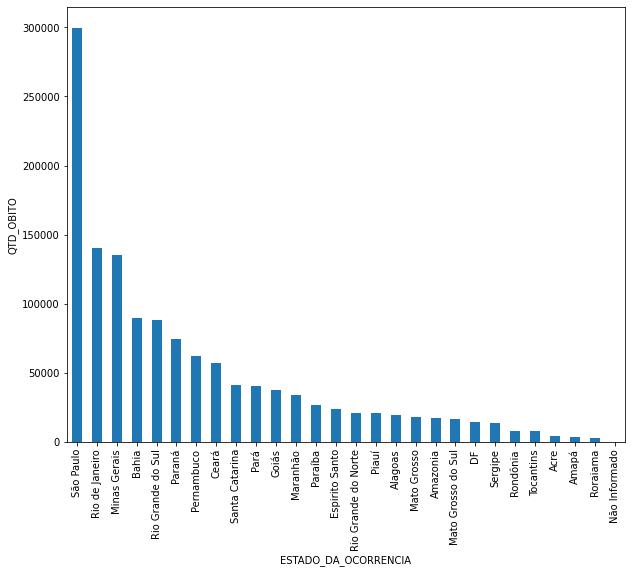

In [77]:
df_pandas.groupby(['ESTADO_DA_OCORRENCIA']).size().sort_values(ascending=False).plot.bar(figsize=(10,8),xlabel = 'ESTADO_DA_OCORRENCIA', ylabel= 'QTD_OBITO')

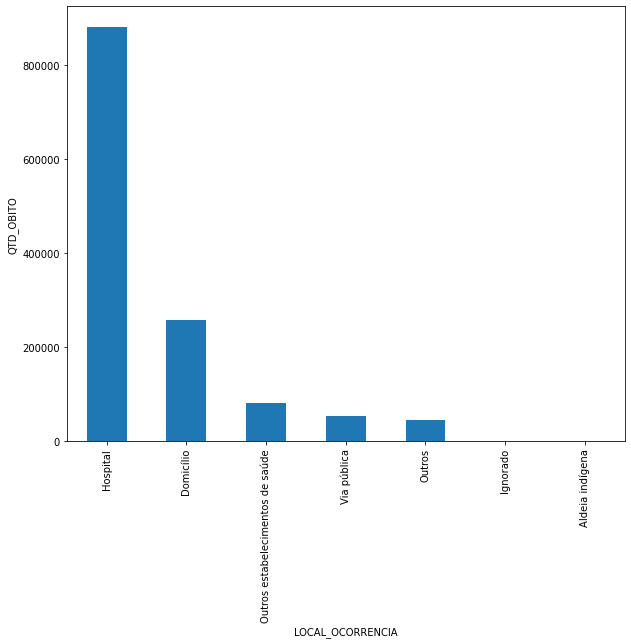

In [78]:
df_pandas.groupby(['LOCAL_OCORRENCIA']).size().sort_values(ascending=False).plot.bar(figsize=(10,8),xlabel = 'LOCAL_OCORRENCIA', ylabel= 'QTD_OBITO')

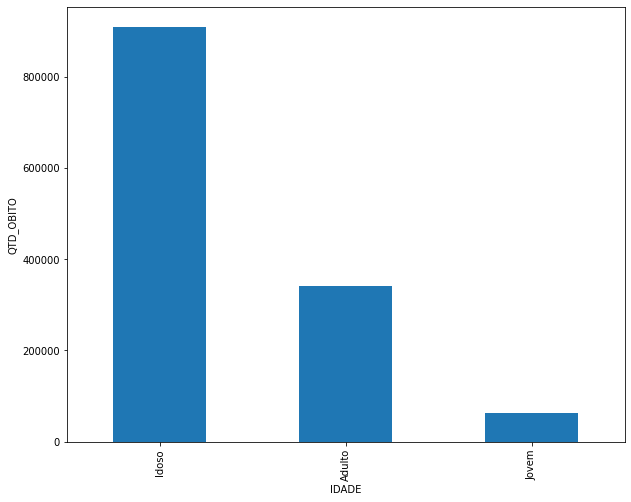

In [80]:
df_pandas.groupby(['IDADE']).size().sort_values(ascending=False).plot.bar(figsize=(10,8),xlabel = 'IDADE', ylabel= 'QTD_OBITO')

##**CONVERTENDO DATAFRAME EM CSV E ENVIANDO PARA O BUCKET**

In [79]:
#df_pandas.to_csv('gs://projeto-final/tratados/df_2018.csv', index=False)